# 0-Libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay, balanced_accuracy_score
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.optimizers import Adam
#from keras.backend import expand_dims
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.layers import Activation, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization, SpatialDropout1D

In [7]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# 1- Load Data

In [8]:
s_aureus = pd.read_csv('s_aureus_driams_a_bin3_2000_20000Da.csv')
s_aureus.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19991,19994,19997,code,species,Oxacillin,Clindamycin,Ceftriaxone,Ciprofloxacin,Fusidic acid
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,35.5,20.5,27.342857,029f0abf-1664-424f-88cb-11c9c8af2b11,Staphylococcus aureus,0.0,0.0,0.0,0.0,1.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,30.0,40.5,34.695238,08149af1-10f5-4f02-81d8-3d46d66d4a7a,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,2.5,30.5,11.288462,08fe3876-ecee-4ddc-9aa9-a84f605757f7,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,15.5,8.0,20.057143,0a9fdd4b-7180-47c0-849e-cb32d46da94c,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,25.5,32.0,24.990476,0d82f4c4-473c-49d8-8c85-e3e36e96d047,Staphylococcus aureus,1.0,0.0,1.0,1.0,0.0


# Preprocessing Data

In [9]:
s_aureus_oxacillin = s_aureus.drop(columns=['code','species', 'Clindamycin', 'Ceftriaxone', 'Ciprofloxacin', 'Fusidic acid'])
s_aureus_oxacillin.dropna(axis=0, how="any", inplace=True)

In [10]:
s_aureus_ceftriaxone = s_aureus.drop(columns=['Oxacillin', 'Clindamycin', 'Ceftriaxone', 'Fusidic acid'])
#ceftriaxone.dropna(axis=0, how="any", inplace=True)
s_aureus_ceftriaxone.dropna(axis=0, how="any", inplace=True)
s_aureus_ceftriaxone.shape

(3757, 6003)

In [11]:
s_aureus_oxacillin.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Oxacillin
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,14.333333,24.0,68.0,19.0,19.000000,50.0,35.5,20.5,27.342857,0.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,15.666667,39.0,19.5,42.0,69.666667,31.0,30.0,40.5,34.695238,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,20.666667,17.0,2.0,18.0,18.000000,11.5,2.5,30.5,11.288462,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,22.333333,33.0,29.0,14.5,21.666667,24.5,15.5,8.0,20.057143,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,26.666667,25.5,18.0,53.5,23.000000,24.5,25.5,32.0,24.990476,1.0


In [12]:
print('clase minoritaria',s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].shape[0])
print('clase mayoritaria',s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 0].shape[0])

clase minoritaria 726
clase mayoritaria 3064


## Enfoque en clase minoritaria

In [13]:
minority_class = s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].drop(columns=['Oxacillin'])


In [14]:
minority_class

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19970,19973,19976,19979,19982,19985,19988,19991,19994,19997
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,16.5,26.666667,25.5,18.0,53.5,23.000000,24.5,25.5,32.0,24.990476
10,233.142857,282.500000,276.142857,216.428571,198.000000,255.000000,225.571429,228.571429,190.142857,241.375000,...,14.0,14.333333,18.0,25.5,4.5,32.333333,21.5,18.0,31.5,16.295238
15,539.571429,631.250000,579.000000,482.857143,673.571429,644.714286,527.714286,544.142857,514.428571,525.000000,...,60.0,16.666667,26.5,29.5,26.0,7.333333,18.0,17.0,30.0,23.180952
20,808.571429,957.625000,807.285714,656.857143,747.714286,801.571429,805.857143,727.857143,712.571429,675.625000,...,25.5,27.333333,31.0,59.5,16.5,28.333333,81.0,34.5,36.5,30.161905
24,694.285714,700.750000,525.571429,691.285714,687.857143,693.714286,596.142857,614.714286,453.571429,530.000000,...,8.5,16.000000,24.5,24.5,25.5,3.333333,5.0,13.5,23.5,20.771429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3758,348.000000,417.285714,323.142857,357.142857,359.428571,365.571429,360.875000,340.285714,331.857143,334.142857,...,21.5,26.666667,21.0,22.0,20.5,30.666667,14.5,22.5,26.0,24.800000
3765,440.600000,459.857143,337.714286,331.857143,375.571429,343.750000,395.857143,324.142857,313.571429,336.571429,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3766,554.714286,591.142857,518.625000,518.714286,457.571429,511.571429,492.428571,540.571429,544.000000,574.375000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.024259
3769,206.571429,192.571429,192.571429,226.000000,194.125000,222.428571,252.714286,216.428571,190.857143,189.571429,...,3.5,1.666667,5.5,4.0,4.0,1.000000,4.5,2.0,1.5,2.000000


In [15]:
from sdv.metadata import SingleTableMetadata

# Crear un objeto Metadata para el dataset
metadata = SingleTableMetadata()

# Detectar automáticamente los tipos de datos del DataFrame
metadata.detect_from_dataframe(minority_class)

# Visualizar el metadata generado
print(metadata.to_dict())

{'METADATA_SPEC_VERSION': 'SINGLE_TABLE_V1', 'columns': {'2000': {'sdtype': 'numerical'}, '2003': {'sdtype': 'numerical'}, '2006': {'sdtype': 'numerical'}, '2009': {'sdtype': 'numerical'}, '2012': {'sdtype': 'numerical'}, '2015': {'sdtype': 'numerical'}, '2018': {'sdtype': 'numerical'}, '2021': {'sdtype': 'numerical'}, '2024': {'sdtype': 'numerical'}, '2027': {'sdtype': 'numerical'}, '2030': {'sdtype': 'numerical'}, '2033': {'sdtype': 'numerical'}, '2036': {'sdtype': 'numerical'}, '2039': {'sdtype': 'numerical'}, '2042': {'sdtype': 'numerical'}, '2045': {'sdtype': 'numerical'}, '2048': {'sdtype': 'numerical'}, '2051': {'sdtype': 'numerical'}, '2054': {'sdtype': 'numerical'}, '2057': {'sdtype': 'numerical'}, '2060': {'sdtype': 'numerical'}, '2063': {'sdtype': 'numerical'}, '2066': {'sdtype': 'numerical'}, '2069': {'sdtype': 'numerical'}, '2072': {'sdtype': 'numerical'}, '2075': {'sdtype': 'numerical'}, '2078': {'sdtype': 'numerical'}, '2081': {'sdtype': 'numerical'}, '2084': {'sdtype': 

In [16]:
from sdv.single_table import GaussianCopulaSynthesizer

synthesizer = GaussianCopulaSynthesizer(metadata)

/home/hpinto/.local/lib/python3.9/site-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/home/hpinto/.local/lib/python3.9/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [17]:
synthesizer.fit(
    data=minority_class
)

In [18]:
s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 0].shape[0]-s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].shape[0]

2338

In [19]:
synthetic_data = synthesizer.sample(
    num_rows=s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 0].shape[0]-s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].shape[0]
)

In [20]:
synthetic_data.shape

(2338, 6000)

In [21]:
combined_data = pd.concat([synthetic_data, s_aureus_oxacillin], ignore_index=True)


In [22]:
combined_data = combined_data.fillna(1)

In [23]:
s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 0].shape

(3064, 6001)

In [24]:
combined_data.shape

(6128, 6001)

In [25]:
X = combined_data.iloc[:, 0:6000].values  # variables independientes (espectros de masa)
y = combined_data.iloc[:, 6000].values    # variable dependientes (resistencia a ciprofloxacin)
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

In [27]:
print(pd.Series(y_train).value_counts())


0.0    2451
1.0    2451
Name: count, dtype: int64


In [28]:
scaler=Normalizer(norm='max')
sc_X = scaler
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [29]:
sample_size = X_train.shape[0] # numero de muestras en el set de datos
time_steps  = X_train.shape[1] # numero de atributos en el set de datos
input_dimension = 1            #

X_train_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [30]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)
early_st = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

n_timesteps = X_train_reshaped.shape[1] #
n_features  = X_train_reshaped.shape[2] #

# Create and fit DeepAMR model

In [31]:
model = Sequential(name="Modelo_s_aureus_ciprofloxacin")
init_mode = 'normal'
model.add(Conv1D(filters=(64), kernel_size=(17), input_shape = (n_timesteps,n_features), name='Conv_1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_1"))

model.add(Conv1D(filters=(128), kernel_size=(9),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name='Conv_2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_2"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode,kernel_regularizer=regularizers.l2(0.0001),   name='Conv_3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_3"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),   name='Conv_4'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_4"))

model.add(Flatten())
model.add(Dropout(0.65))
model.add(Dense(256, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_0"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_1"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name="fully_connected_2"))
model.add(Dense(n_features, activation='sigmoid', name="OUT_Layer"))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy',  metrics=METRICS)
model.summary()

Model: "Modelo_s_aureus_ciprofloxacin"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv1D)             (None, 5984, 64)          1152      
                                                                 
 batch_normalization (BatchN  (None, 5984, 64)         256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 5984, 64)          0         
                                                                 
 MaxPooling1D_1 (MaxPooling1  (None, 2992, 64)         0         
 D)                                                              
                                                                 
 Conv_2 (Conv1D)             (None, 2984, 128)         73856     
                                                                 
 batch_normalization_1 (Batc  (None, 

In [32]:
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=10, verbose=1, validation_split=0.1, callbacks=[reduce_lr,early_st])

Epoch 1/100


2024-12-24 09:56:34.915864: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2024-12-24 09:56:34.943033: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-24 09:56:35.060526: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


442/442 [==============================] - 16s 29ms/step - loss: 6.2735 - tp: 1371.0000 - fp: 827.0000 - tn: 1385.0000 - fn: 828.0000 - accuracy: 0.6248 - precision: 0.6237 - recall: 0.6235 - auc: 0.6694 - prc: 0.6512 - val_loss: 5.7954 - val_tp: 74.0000 - val_fp: 12.0000 - val_tn: 227.0000 - val_fn: 178.0000 - val_accuracy: 0.6130 - val_precision: 0.8605 - val_recall: 0.2937 - val_auc: 0.7996 - val_prc: 0.7812 - lr: 1.0000e-04
Epoch 2/100
442/442 [==============================] - 12s 27ms/step - loss: 5.2589 - tp: 1745.0000 - fp: 423.0000 - tn: 1789.0000 - fn: 454.0000 - accuracy: 0.8012 - precision: 0.8049 - recall: 0.7935 - auc: 0.8888 - prc: 0.8988 - val_loss: 4.9689 - val_tp: 175.0000 - val_fp: 0.0000e+00 - val_tn: 239.0000 - val_fn: 77.0000 - val_accuracy: 0.8432 - val_precision: 1.0000 - val_recall: 0.6944 - val_auc: 0.9369 - val_prc: 0.9551 - lr: 1.0000e-04
Epoch 3/100
442/442 [==============================] - 12s 27ms/step - loss: 4.6442 - tp: 1857.0000 - fp: 221.0000 - tn: 

# Evaluate the model

In [33]:
y_pred  = model.predict(X_test_reshaped)
y_pred = (y_pred>0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)

39/39 [==============================] - 1s 9ms/step
[[597  16]
 [ 51 562]]


In [34]:
print("balanced acuracy:", balanced_accuracy_score(y_test, y_pred))

balanced acuracy: 0.9453507340946166


In [35]:
target_names=["0","1"]
print(classification_report(y_test, y_pred, target_names=target_names))

train_predictions_baseline = model.predict(X_train_reshaped, batch_size=10)
test_predictions_baseline = model.predict(X_test_reshaped, batch_size=10)

baseline_results = model.evaluate(X_test_reshaped, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       613
           1       0.97      0.92      0.94       613

    accuracy                           0.95      1226
   macro avg       0.95      0.95      0.95      1226
weighted avg       0.95      0.95      0.95      1226

123/123 [==============================] - 1s 6ms/step
loss :  0.5020139217376709
tp :  562.0
fp :  16.0
tn :  597.0
fn :  51.0
accuracy :  0.945350706577301
precision :  0.9723183512687683
recall :  0.9168025851249695
auc :  0.9876506924629211
prc :  0.9896658658981323



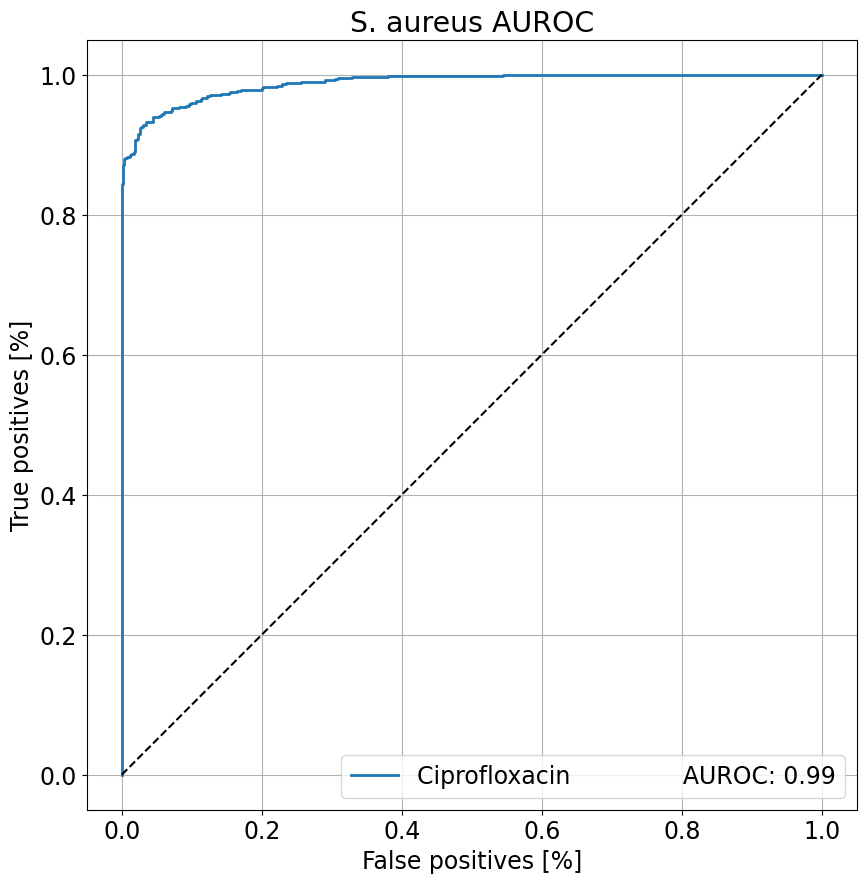

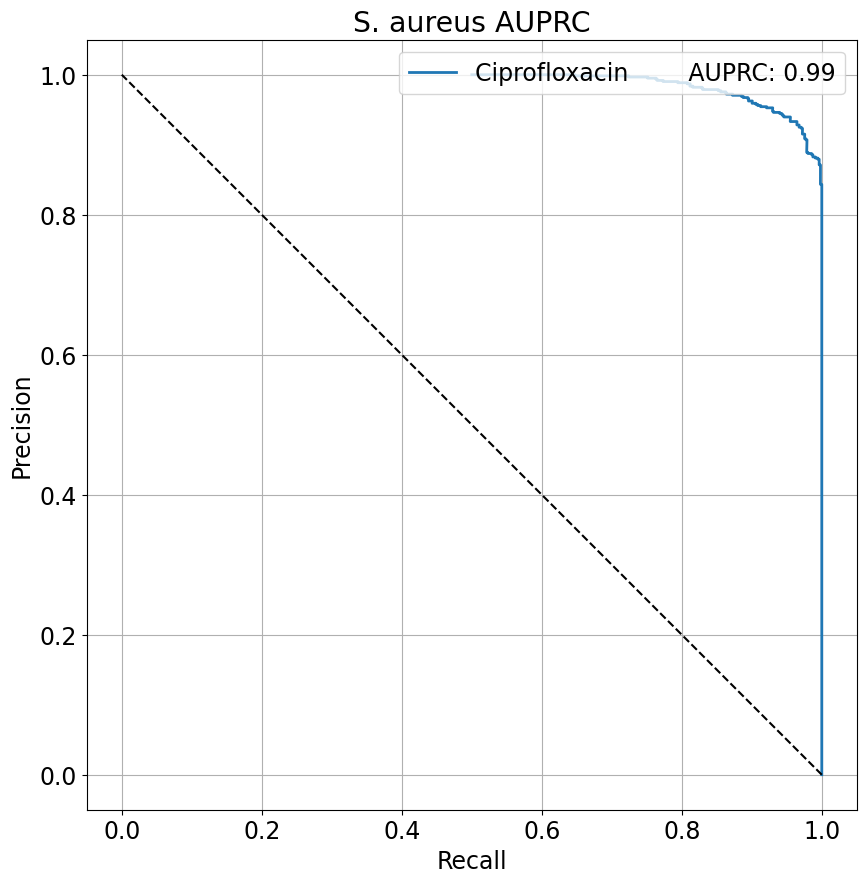

In [36]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams.update({'font.size': 17})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.title('E. coli CNN')
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.title('S. aureus AUROC')

  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
plot_roc("Ciprofloxacin               AUROC: %0.2f" % baseline_results[8], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='lower right')
plt.savefig('s_aureus_auroc.png', bbox_inches='tight')
plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.title('S. aureus AUPRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot([1, 0], [0, 1], 'k--')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Ciprofloxacin        AUPRC: %0.2f" % baseline_results[9], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='upper right')
plt.savefig('s_aureus_auprc.png', bbox_inches='tight')
plt.show()